In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegressionCV as LogReg
from sklearn import metrics
import matplotlib.pyplot as plt
import gc; gc.enable()
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [2]:
folder_path = '../input/'
train_identity = pd.read_csv('train_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')


def combine_data(transaction, identity):
    data = pd.merge(transaction, 
                    identity, 
                    on='TransactionID', 
                    how='left')
    return data


train = combine_data(train_transaction, train_identity)
# train = train_transaction.copy()
del train_transaction; del train_identity; gc.collect()


35

In [3]:
t_identity=pd.read_csv('test_identity.csv')
t_transaction=pd.read_csv('test_transaction.csv')

test = combine_data(t_transaction, t_identity)
# train = train_transaction.copy()
del t_transaction; del t_identity; gc.collect()

28

In [4]:
def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

## Function to reduce the DF size
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

def CalcOutliers(df_num): 

    # calculating mean and std of the array
    data_mean, data_std = np.mean(df_num), np.std(df_num)

    # seting the cut line to both higher and lower values
    # You can change this value
    cut = data_std * 3

    #Calculating the higher and lower cut values
    lower, upper = data_mean - cut, data_mean + cut

    # creating an array of lower, higher and total outlier values 
    outliers_lower = [x for x in df_num if x < lower]
    outliers_higher = [x for x in df_num if x > upper]
    outliers_total = [x for x in df_num if x < lower or x > upper]

    # array without outlier values
    outliers_removed = [x for x in df_num if x > lower and x < upper]
    
    print('Identified lowest outliers: %d' % len(outliers_lower)) # printing total number of values in lower cut of outliers
    print('Identified upper outliers: %d' % len(outliers_higher)) # printing total number of values in higher cut of outliers
    print('Total outlier observations: %d' % len(outliers_total)) # printing total number of values outliers of both sides
    print('Non-outlier observations: %d' % len(outliers_removed)) # printing total number of non outlier values
    print("Total percentual of Outliers: ", round((len(outliers_total) / len(outliers_removed) )*100, 4)) # Percentual of outliers in points
    
    return

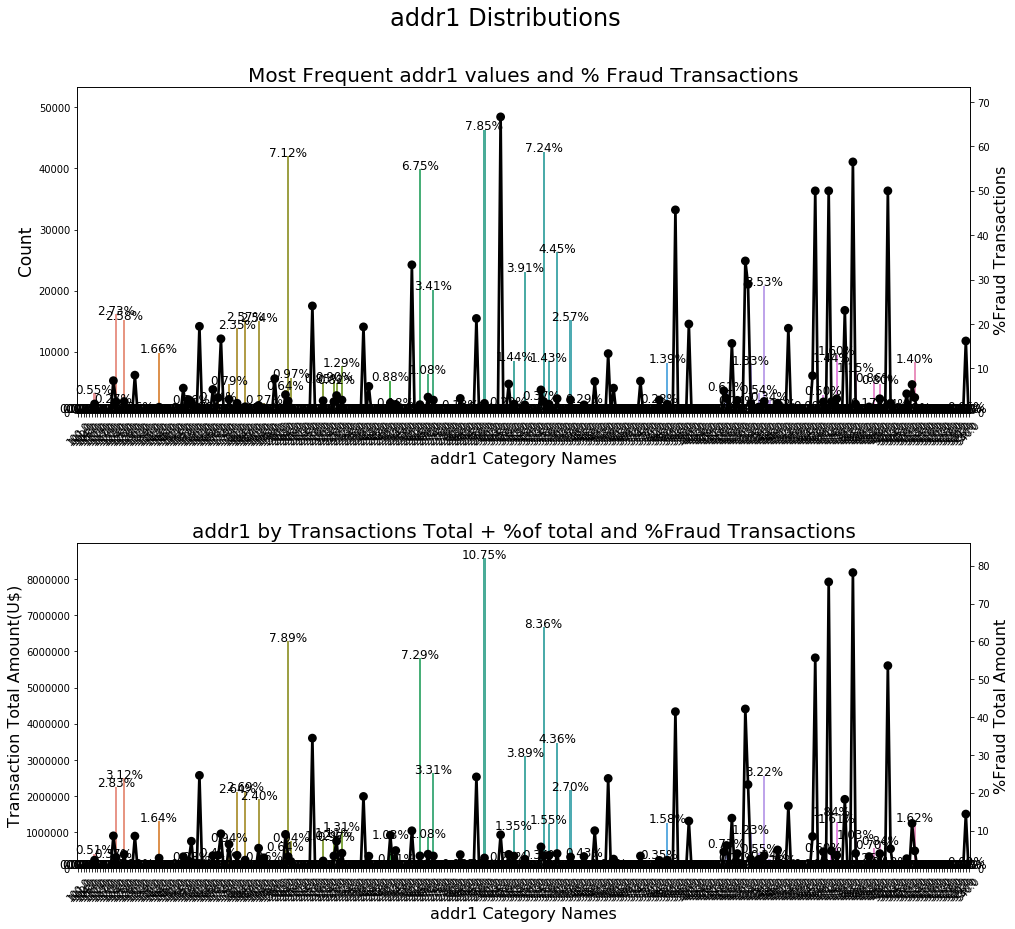

In [5]:
total = len(train)
total_amt = train.groupby(['isFraud'])['TransactionAmt'].sum().sum()
def ploting_cnt_amt(df, col, lim=2000):
    tmp = pd.crosstab(df[col], df['isFraud'], normalize='index') * 100
    tmp = tmp.reset_index()
    tmp.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    
    plt.figure(figsize=(16,14))    
    plt.suptitle(f'{col} Distributions ', fontsize=24)
    
    plt.subplot(211)
    g = sns.countplot( x=col,  data=df, order=list(tmp[col].values))
    gt = g.twinx()
    gt = sns.pointplot(x=col, y='Fraud', data=tmp, order=list(tmp[col].values),
                       color='black', legend=False, )
    gt.set_ylim(0,tmp['Fraud'].max()*1.1)
    gt.set_ylabel("%Fraud Transactions", fontsize=16)
    g.set_title(f"Most Frequent {col} values and % Fraud Transactions", fontsize=20)
    g.set_xlabel(f"{col} Category Names", fontsize=16)
    g.set_ylabel("Count", fontsize=17)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    sizes = []
    for p in g.patches:
        height = p.get_height()
        sizes.append(height)
        g.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total*100),
                ha="center",fontsize=12) 
        
    g.set_ylim(0,max(sizes)*1.15)
    
    #########################################################################
    perc_amt = (df.groupby(['isFraud',col])['TransactionAmt'].sum() \
                / df.groupby([col])['TransactionAmt'].sum() * 100).unstack('isFraud')
    perc_amt = perc_amt.reset_index()
    perc_amt.rename(columns={0:'NoFraud', 1:'Fraud'}, inplace=True)
    amt = df.groupby([col])['TransactionAmt'].sum().reset_index()
    perc_amt = perc_amt.fillna(0)
    plt.subplot(212)
    g1 = sns.barplot(x=col, y='TransactionAmt', 
                       data=amt, 
                       order=list(tmp[col].values))
    g1t = g1.twinx()
    g1t = sns.pointplot(x=col, y='Fraud', data=perc_amt, 
                        order=list(tmp[col].values),
                       color='black', legend=False, )
    g1t.set_ylim(0,perc_amt['Fraud'].max()*1.1)
    g1t.set_ylabel("%Fraud Total Amount", fontsize=16)
    g.set_xticklabels(g.get_xticklabels(),rotation=45)
    g1.set_title(f"{col} by Transactions Total + %of total and %Fraud Transactions", fontsize=20)
    g1.set_xlabel(f"{col} Category Names", fontsize=16)
    g1.set_ylabel("Transaction Total Amount(U$)", fontsize=16)
    g1.set_xticklabels(g.get_xticklabels(),rotation=45)    
    
    for p in g1.patches:
        height = p.get_height()
        g1.text(p.get_x()+p.get_width()/2.,
                height + 3,
                '{:1.2f}%'.format(height/total_amt*100),
                ha="center",fontsize=12) 
        
    plt.subplots_adjust(hspace=.4, top = 0.9)
    plt.show()
    
ploting_cnt_amt(train, 'addr1')

In [6]:
train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


In [7]:
len(train)

590540

In [8]:
len(test)

506691

In [9]:
target = "isFraud"
_id = "TransactionID"

def data_prep(data, isTest=0):
    keep_cols = [col for col in data.columns.tolist() if col not in [target, _id]]
#     keep_cols = ['TransactionDT', 'TransactionAmt', 'ProductCD', 'card4', 
#                  'card6', 'addr1', 'addr2', 'dist1', 'dist2', 'P_emaildomain', 'R_emaildomain']
    
    if isTest:
        pass
    else:
        keep_cols += [target]
        
    used_cols = [col for col in keep_cols if col not in [target, _id]]

    return data[keep_cols].copy(), keep_cols, used_cols

train, keep_cols, used_cols = data_prep(train)
test_id = test['TransactionID']
test=test[used_cols]
gc.collect()

231600

In [10]:
import pandas.core.algorithms as algos
from pandas import Series
import scipy.stats.stats as stats
import re
import traceback
import string


max_bin = 20
force_bin = 3


# define a binning function
def mono_bin(Y, X, n = max_bin):
    
    df1 = pd.DataFrame({"X": X, "Y": Y})
    justmiss = df1[['X','Y']][df1.X.isnull()]
    notmiss = df1[['X','Y']][df1.X.notnull()]
    r = 0
    while np.abs(r) < 1:
        try:
            d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.qcut(notmiss.X, n)})
            d2 = d1.groupby('Bucket', as_index=True)
            r, p = stats.spearmanr(d2.mean().X, d2.mean().Y)
            n = n - 1 
        except Exception as e:
            n = n - 1

    if len(d2) == 1:
        n = force_bin         
        bins = algos.quantile(notmiss.X, np.linspace(0, 1, n))
        if len(np.unique(bins)) == 2:
            bins = np.insert(bins, 0, 1)
            bins[1] = bins[1]-(bins[1]/2)
        d1 = pd.DataFrame({"X": notmiss.X, "Y": notmiss.Y, "Bucket": pd.cut(notmiss.X, np.unique(bins),include_lowest=True)}) 
        d2 = d1.groupby('Bucket', as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["MIN_VALUE"] = d2.min().X
    d3["MAX_VALUE"] = d2.max().X
    d3["COUNT"] = d2.count().Y
    d3["EVENT"] = d2.sum().Y
    d3["NONEVENT"] = d2.count().Y - d2.sum().Y
    d3=d3.reset_index(drop=True)
    
    if len(justmiss.index) > 0:
        d4 = pd.DataFrame({'MIN_VALUE':np.nan},index=[0])
        d4["MAX_VALUE"] = np.nan
        d4["COUNT"] = justmiss.count().Y
        d4["EVENT"] = justmiss.sum().Y
        d4["NONEVENT"] = justmiss.count().Y - justmiss.sum().Y
        d3 = d3.append(d4,ignore_index=True)
    
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    
    return(d3)

def char_bin(Y, X):
        
    df1 = pd.DataFrame({"X": X, "Y": Y})
    df2 = df1.groupby('X',as_index=True)
    
    d3 = pd.DataFrame({},index=[])
    d3["COUNT"] = df2.count().Y
    d3["MIN_VALUE"] = df2.groups
    d3["MAX_VALUE"] = df2.groups
    d3["EVENT"] = df2.sum().Y
    d3["NONEVENT"] = df2.count().Y - df2.sum().Y     
    d3["EVENT_RATE"] = d3.EVENT/d3.sum().EVENT
    d3["NON_EVENT_RATE"] = d3.NONEVENT/d3.sum().NONEVENT
    d3["WOE"] = np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["IV"] = (d3.EVENT_RATE-d3.NON_EVENT_RATE)*np.log(d3.EVENT_RATE/d3.NON_EVENT_RATE)
    d3["VAR_NAME"] = "VAR"
    d3 = d3[['VAR_NAME','MIN_VALUE', 'MAX_VALUE', 'COUNT', 'EVENT', 'EVENT_RATE', 'NONEVENT', 'NON_EVENT_RATE', 'WOE', 'IV']]       
    d3 = d3.replace([np.inf, -np.inf], 0)
    d3.IV = d3.IV.sum()
    d3 = d3.reset_index(drop=True)
    
    return(d3)

def data_vars(df1, target):
    
    stack = traceback.extract_stack()
    filename, lineno, function_name, code = stack[-2]
    vars_name = re.compile(r'\((.*?)\).*$').search(code).groups()[0]
    final = (re.findall(r"[\w']+", vars_name))[-1]
    
    x = df1.dtypes.index
    count = -1
    
    for i in x:
        if i.upper() not in (final.upper()):
            if np.issubdtype(df1[i], np.number) and len(Series.unique(df1[i])) > 2:
                conv = mono_bin(target, df1[i])
                conv["VAR_NAME"] = i
                count = count + 1
            else:
                conv = char_bin(target, df1[i])
                conv["VAR_NAME"] = i            
                count = count + 1
                
            if count == 0:
                iv_df = conv
            else:
                iv_df = iv_df.append(conv,ignore_index=True)
    
    iv = pd.DataFrame({'IV':iv_df.groupby('VAR_NAME').IV.max()})
    
    iv['STRENGTH'] = 'useless'
    iv.loc[iv['IV'] >= 0.02, 'STRENGTH'] = 'weak'
    iv.loc[iv['IV'] >= 0.1, 'STRENGTH'] = 'medium'
    iv.loc[iv['IV'] >= 0.3, 'STRENGTH'] = 'strong'
    iv.loc[iv['IV'] > 0.5, 'STRENGTH'] = 'suspicious'
    
    iv = iv.reset_index()
    
    return(iv_df,iv)


In [11]:
import pandas as pd
import numpy as np

from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.externals import joblib 


class BaseTransformer(BaseEstimator, TransformerMixin):
    """
    Base class.
    """
    def __init__(self, columns=None, suffix='_base'):
        self.columns = columns
        self.suffix = suffix
        self.scaler = None
    
    def fit(self, X, y=None):
        if self.columns is None:
            self.columns = X.columns.tolist()
        self.scaler.fit(X[self.columns])
    
    def transform(self, X, y=None):
        return None
    
    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)
    
    def save(self, path):
        joblib.dump((self.columns, self.suffix, self.scaler), path)
    
    def load(self, path):
        self.columns, self.suffix, self.scaler = joblib.load(path)

In [12]:
class WoeEncoder(BaseTransformer):
    """
    Weight of Evidence Encoding.
    """
    def __init__(self, columns=None, suffix="_woe"):
        self.columns = columns
        self.suffix = suffix
        self.iv_df = pd.DataFrame()
        self.iv = pd.DataFrame()
        
    def fit(self, df, y=None):
        if self.columns is None:
            self.columns = df.columns.tolist()
        
        iv_df, iv = data_vars(df[self.columns], y)
        
        self.iv_df = iv_df
        self.iv = iv
    
    def transform(self, df):
        for col in self.columns:
            LBs = self.iv_df[self.iv_df['VAR_NAME'] == col]['MIN_VALUE'].tolist()
            UBs = self.iv_df[self.iv_df['VAR_NAME'] == col]['MAX_VALUE'].tolist()
            
            criteria = [df[col].between(LBs[i], UBs[i]) for i in range(len(LBs))]
            values = self.iv_df[self.iv_df['VAR_NAME'] == col]['WOE'].tolist()
            default = self.iv_df[self.iv_df['VAR_NAME'] == col][self.iv_df['MIN_VALUE'].isna()]['WOE'].mean()

            df[col + self.suffix] = np.select(criteria, values, default)

            del LBs; del UBs; del criteria; del values; del default; gc.collect()
            
        return df
    
    def fit_transform(self, df, y):
        self.fit(df, y)
        return self.transform(df)

In [13]:
woe = WoeEncoder(columns=used_cols, suffix='')

In [14]:
train.id_31.unique()

array([nan, 'samsung browser 6.2', 'mobile safari 11.0', 'chrome 62.0',
       'chrome 62.0 for android', 'edge 15.0', 'mobile safari generic',
       'chrome 49.0', 'chrome 61.0', 'edge 16.0', 'safari generic',
       'edge 14.0', 'chrome 56.0 for android', 'firefox 57.0',
       'chrome 54.0 for android', 'mobile safari uiwebview', 'chrome',
       'chrome 62.0 for ios', 'firefox', 'chrome 60.0 for android',
       'mobile safari 10.0', 'chrome 61.0 for android',
       'ie 11.0 for desktop', 'ie 11.0 for tablet', 'mobile safari 9.0',
       'chrome generic', 'other', 'chrome 59.0 for android',
       'firefox 56.0', 'android webview 4.0', 'chrome 55.0', 'opera 49.0',
       'ie', 'chrome 55.0 for android', 'firefox 52.0',
       'chrome 57.0 for android', 'chrome 56.0',
       'chrome 46.0 for android', 'chrome 58.0', 'firefox 48.0',
       'chrome 59.0', 'samsung browser 4.0', 'edge 13.0',
       'chrome 53.0 for android', 'chrome 58.0 for android',
       'chrome 60.0', 'mobile sa

In [15]:
for i in used_cols:
    print(i, type(train[i][0]))

TransactionDT <class 'numpy.int64'>
TransactionAmt <class 'numpy.float64'>
ProductCD <class 'str'>
card1 <class 'numpy.int64'>
card2 <class 'numpy.float64'>
card3 <class 'numpy.float64'>
card4 <class 'str'>
card5 <class 'numpy.float64'>
card6 <class 'str'>
addr1 <class 'numpy.float64'>
addr2 <class 'numpy.float64'>
dist1 <class 'numpy.float64'>
dist2 <class 'numpy.float64'>
P_emaildomain <class 'float'>
R_emaildomain <class 'float'>
C1 <class 'numpy.float64'>
C2 <class 'numpy.float64'>
C3 <class 'numpy.float64'>
C4 <class 'numpy.float64'>
C5 <class 'numpy.float64'>
C6 <class 'numpy.float64'>
C7 <class 'numpy.float64'>
C8 <class 'numpy.float64'>
C9 <class 'numpy.float64'>
C10 <class 'numpy.float64'>
C11 <class 'numpy.float64'>
C12 <class 'numpy.float64'>
C13 <class 'numpy.float64'>
C14 <class 'numpy.float64'>
D1 <class 'numpy.float64'>
D2 <class 'numpy.float64'>
D3 <class 'numpy.float64'>
D4 <class 'numpy.float64'>
D5 <class 'numpy.float64'>
D6 <class 'numpy.float64'>
D7 <class 'numpy.f

In [16]:
Sum_C_Train = sum([train.C1, train.C2,train.C3,train.C4,train.C5,train.C6,train.C7,train.C8,train.C9,train.C10,train.C11,train.C12, train.C13, train.C14])  
Sum_C_Test = sum([test.C1,test.C2,test.C3,test.C4,test.C5,test.C6,test.C7,test.C8,test.C9,test.C10,test.C11,test.C12, test.C13, test.C14])

In [17]:
Sum_D_Train = sum([train.D1,train.D2,train.D3,train.D4,train.D5,train.D6,train.D7,train.D8,train.D9,train.D10,train.D11,train.D12,train.D13,train.D14,train.D15])
Sum_D_Test = sum([test.D1, test.D2, test.D3, test.D4, test.D5, test.D6, test.D7, test.D8, test.D9, test.D10, test.D11, test.D12, test.D13, test.D14, test.D15])

In [18]:
List_of_Ms=['M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']
tired = []
for i in List_of_Ms:
    poggies = []
    for j in train[i]:
        if j == 'T':
            poggies.append(1)
        else:
            poggies.append(0)
    tired.append(poggies)
    
from numpy import array
tired = array(tired)
tired_train = sum(tired,0)

tired_test = []
for i in List_of_Ms:
    poggies_test = []
    for j in test[i]:
        if j == 'T':
            poggies_test.append(1)
        else:
            poggies_test.append(0)
    tired_test.append(poggies_test)
    
from numpy import array
tired_test = array(tired_test)
tired_test = sum(tired_test,0)

In [19]:
is_apple = []
for i in train.id_31:
    if 'ios' in str(i):
        is_apple.append('apple')
    elif 'safari' in str(i):
        is_apple.append('apple')
    elif i is np.nan:
        is_apple.append('unknown')
    else:
        is_apple.append('not_apple')

is_apple_test = []
for i in test.id_31:
    if 'ios' in str(i):
        is_apple_test.append('apple')
    elif 'safari' in str(i):
        is_apple_test.append('apple')
    elif i is np.nan:
        is_apple_test.append('unknown')
    else:
        is_apple_test.append('not_apple')


In [20]:
is_apple[:5]

['unknown', 'unknown', 'unknown', 'unknown', 'not_apple']

In [21]:
p_mail_list = []
for i in train.P_emaildomain:
    if str(i) == 'mail.com':
        p_mail_list.append(1)
    else:
        p_mail_list.append(0)

r_mail_list = []
for i in train.R_emaildomain:
    if str(i) == 'gmail.com':
        r_mail_list.append(1)
    elif str(i) == 'icloud.com':
        r_mail_list.append(1)
    else:
        r_mail_list.append(0)



In [22]:
p_mail_list_test = []
for i in test.P_emaildomain:
    if str(i) == 'mail.com':
        p_mail_list_test.append(1)
    else:
        p_mail_list_test.append(0)

r_mail_list_test = []
for i in test.R_emaildomain:
    if str(i) == 'gmail.com':
        r_mail_list_test.append(1)
    elif str(i) == 'icloud.com':
        r_mail_list_test.append(1)
    else:
        r_mail_list_test.append(0)



In [23]:
cum_mail_list=[sum(x) for x in zip(p_mail_list, r_mail_list)]
len(cum_mail_list)

590540

In [24]:
cum_mail_list_test=[sum(x) for x in zip(p_mail_list_test, r_mail_list_test)]
len(cum_mail_list_test)

506691

In [25]:
len(is_apple)

590540

In [26]:
for i in range(len(cum_mail_list)):
    if cum_mail_list[i] == 0:
        cum_mail_list[i] = 'zero'
    if cum_mail_list[i] == 1:
        cum_mail_list[i] = 'one'
    if cum_mail_list[i] == 2:
        cum_mail_list[i] = 'two'
        
for i in range(len(cum_mail_list_test)):
    if cum_mail_list_test[i] == 0:
        cum_mail_list_test[i] = 'zero'
    if cum_mail_list_test[i] == 1:
        cum_mail_list_test[i] = 'one'
    if cum_mail_list_test[i] == 2:
        cum_mail_list_test[i] = 'two'

In [27]:
cum_mail_list

['zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'one',
 'zero',
 'one',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'zero',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'one',
 'zero',
 'zero',
 'zero',
 

In [28]:
train.columns.tolist()

['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 

In [29]:
train.addr1=train.addr1.fillna(0)
train.addr2=train.addr2.fillna(0)
test.addr1 = test.addr1.fillna(0)
test.addr2 = test.addr2.fillna(0)
train.dist1 = train.dist1.fillna(0)
train.dist2 = train.dist2.fillna(0)
test.dist1 = train.dist1.fillna(0)
test.dist2 = test.dist2.fillna(0)

In [30]:
mean_address_train= (train.addr1+train.addr2)/2
mean_address_test = (test.addr1+test.addr2)/2
mean_distance_train= (train.dist1+train.dist2)/2
mean_distance_test = (test.dist1+test.dist2)/2


In [31]:
train['is_apple']=is_apple
test['is_apple']=is_apple_test
train['sus_email']=cum_mail_list
test['sus_email']=cum_mail_list_test
train['sum_C']=Sum_C_Train
test['sum_C']=Sum_C_Test
train['sum_D']=Sum_D_Train
test['sum_D']=Sum_D_Test
train['sum_M']=tired_train
test['sum_M']=tired_test
train['mean_addr']=mean_address_train
test['mean_addr']=mean_address_test
train['mean_dist']=mean_distance_train
test['mean_dist']=mean_distance_test

In [32]:
used_cols.append('is_apple')
used_cols.append('sus_email')
used_cols.append('sum_C')
used_cols.append('sum_D')
used_cols.append('sum_M')
used_cols.append('mean_addr')
used_cols.append('mean_dist')

In [33]:
used_cols

['TransactionDT',
 'TransactionAmt',
 'ProductCD',
 'card1',
 'card2',
 'card3',
 'card4',
 'card5',
 'card6',
 'addr1',
 'addr2',
 'dist1',
 'dist2',
 'P_emaildomain',
 'R_emaildomain',
 'C1',
 'C2',
 'C3',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'D1',
 'D2',
 'D3',
 'D4',
 'D5',
 'D6',
 'D7',
 'D8',
 'D9',
 'D10',
 'D11',
 'D12',
 'D13',
 'D14',
 'D15',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9',
 'V1',
 'V2',
 'V3',
 'V4',
 'V5',
 'V6',
 'V7',
 'V8',
 'V9',
 'V10',
 'V11',
 'V12',
 'V13',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V28',
 'V29',
 'V30',
 'V31',
 'V32',
 'V33',
 'V34',
 'V35',
 'V36',
 'V37',
 'V38',
 'V39',
 'V40',
 'V41',
 'V42',
 'V43',
 'V44',
 'V45',
 'V46',
 'V47',
 'V48',
 'V49',
 'V50',
 'V51',
 'V52',
 'V53',
 'V54',
 'V55',
 'V56',
 'V57',
 'V58',
 'V59',
 'V60',
 'V61',
 'V62',
 'V63',
 'V64',
 'V65',
 'V66',
 'V67',
 'V68',
 

In [34]:
y = train[target]

train = woe.fit_transform(train[used_cols], y)

In [35]:
test = woe.transform(test[used_cols])

In [36]:
X = train[used_cols].fillna(0)
test = test[used_cols].fillna(0)
del train; gc.collect

<function gc.collect>

In [37]:
X.columns

Index(['TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2',
       'card3', 'card4', 'card5', 'card6', 'addr1',
       ...
       'id_38', 'DeviceType', 'DeviceInfo', 'is_apple', 'sus_email', 'sum_C',
       'sum_D', 'sum_M', 'mean_addr', 'mean_dist'],
      dtype='object', length=439)

In [38]:
clf = LogReg(class_weight='balanced', 
             random_state=42, 
             verbose=1,
             n_jobs=-1,
             scoring='roc_auc')

In [39]:
clf.fit(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  5.5min finished


LogisticRegressionCV(Cs=10, class_weight='balanced', cv='warn', dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='warn', n_jobs=-1, penalty='l2',
                     random_state=42, refit=True, scoring='roc_auc',
                     solver='lbfgs', tol=0.0001, verbose=1)

In [41]:
y_pred = clf.predict_proba(X)

In [42]:
test

,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,...,id_38,DeviceType,DeviceInfo,is_apple,sus_email,sum_C,sum_D,sum_M,mean_addr,mean_dist
0,0.0,-0.037092,-0.554564,-0.026764,-0.062712,-0.353155,-0.007663,-0.104641,-0.377988,0.227207,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.351147,0.0,-0.657761,0.227836,-0.130040
1,0.0,-0.037092,-0.554564,0.128430,-0.062712,-0.353155,-0.007663,-0.104641,-0.377988,-0.335099,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.007654,0.0,0.395845,-0.339089,0.068051
2,0.0,0.035855,-0.554564,0.128430,0.050556,-0.353155,-0.007663,-0.104641,-0.377988,-0.335099,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.351147,0.0,0.395845,-0.339089,-0.130040
3,0.0,0.035855,-0.554564,-0.026764,-0.062712,-0.353155,-0.007663,0.167959,-0.377988,0.227207,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.007654,0.0,-0.657761,0.227836,0.068051
4,0.0,-0.037092,-0.554564,-0.109230,0.050556,-0.353155,-0.020411,0.167959,-0.377988,0.227207,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.351147,0.0,-0.657761,0.227836,0.068051
5,0.0,-0.037092,-0.554564,-0.026764,-0.062712,-0.353155,-0.007663,-0.104641,-0.377988,-0.335099,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.351147,0.0,-0.657761,-0.339089,-0.130040
6,0.0,0.035855,-0.554564,-0.109230,0.050556,-0.353155,-0.007663,0.167959,-0.377988,0.227207,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,-0.310235,0.0,-0.657761,0.227836,0.068051
7,0.0,0.035855,-0.554564,-0.109230,-0.062712,-0.353155,-0.020411,0.167959,0.679113,0.227207,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.007654,0.0,-0.657761,0.227836,0.068051
8,0.0,0.035855,-0.554564,0.128430,-0.062712,-0.353155,-0.007663,-0.104641,-0.377988,-0.335099,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.351147,0.0,-0.657761,-0.339089,0.068051
9,0.0,0.035855,-0.554564,-0.026764,-0.062712,-0.353155,-0.007663,-0.104641,-0.377988,-0.335099,...,0.000000,0.000000,0.000000,-0.520989,-0.324667,0.007654,0.0,-0.657761,-0.339089,-0.130040


In [43]:
test_pred = clf.predict_proba(test)

In [44]:
test_pred=test_pred[:,1]

In [45]:
y_pred = y_pred[:,1]

In [46]:
metrics.roc_auc_score(y, y_pred)

0.8749109308019223

In [47]:
metrics.confusion_matrix(y, y_pred >= 0.95)

array([[567623,   2254],
       [ 14624,   6039]], dtype=int64)

In [48]:
output = pd.DataFrame({'TransactionID': test_id, 'isFraud':test_pred})
output.head()

,TransactionID,isFraud
0,3663549,0.103505
1,3663550,0.267311
2,3663551,0.293468
3,3663552,0.094258
4,3663553,0.316930


In [49]:
output.to_csv('output.csv', index=False)

In [50]:
woe.iv

,VAR_NAME,IV,STRENGTH
0,C1,1.583720e-01,medium
1,C10,5.270157e-01,suspicious
2,C11,1.669697e-01,medium
3,C12,5.212037e-01,suspicious
4,C13,8.812035e-02,weak
5,C14,1.989306e-02,useless
6,C2,1.938104e-01,medium
7,C3,2.626121e-07,useless
8,C4,5.498490e-01,suspicious
9,C5,1.638906e-01,medium


In [56]:
woe.iv.loc[woe.iv.VAR_NAME=='sum_C']

,VAR_NAME,IV,STRENGTH
435,sum_C,0.061316,weak
